# 230968078 - Ishan Suryawanshi - Deep Learning Project - Audio Denoiser From Scratch

## Table of Contents
- Utility Libraries
- Environment Variables
- Audio Utility Functions
- Signal Transform Functions
- Visualization Functions
- Synthetic Noise Generator
- Pipeline
- Preprocessing (Same for both models)
- Resnet Architecture
- Unet Architecture
- Custom Loss functions
- Custom Learning Rate for Optimzer
- Exponential Moving Average
- EDA
- Model Training: Training Unet model and Resnet model side by side
- Qualitative Check
- Visualizing Results
- Picking the Best Model based on val score

This file details a deep learning project focused on audio feature extraction using two distinct, powerful architectures: a UNet and a ResNet. Instead of focusing solely on general audio denoising, our models have demonstrated an exceptional ability to accurately isolate and enhance the fundamental base frequency and harmonic structure of a dominant signal from complex acoustic mixtures. This capability positions the denoiser as a highly effective Frequency-Domain Feature Extractor, providing precise spectral data crucial for advanced signal analysis in various domains.

This precise spectral isolation capability is immensely useful in today's data-driven world, enabling new solutions across several high-value sectors. In Industrial Monitoring and Predictive Maintenance, the models can isolate the specific operational frequency of machinery (e.g., motor rotation) even when masked by heavy factory noise, allowing for early detection of mechanical faults or wear before catastrophic failure occurs. In the Music and Audio Production industries, this extractor can accurately single out the pitch of a specific instrument within an ensemble recording, drastically simplifying tasks like automatic musical transcription or instrument separation. Furthermore, in scientific research involving acoustics, the model offers a reliable method for studying the clean, fundamental properties of a target sound source by effectively suppressing acoustic clutter, thereby turning a noise suppression system into a versatile, high-fidelity signal enhancement tool.

The provided code block distinguishes itself from typical academic research by prioritizing rigorous, side-by-side comparative analysis supported by advanced deep learning engineering practices. Most research papers introduce a single, often highly complex, novel architecture and compare it only against basic baselines. In contrast, this project executes a fair, clean comparison between two fundamental, distinct architectures—the U-Net and a custom 5-block ResNet—trained under identical conditions (data, loss, optimizer, and hyperparameters). The implementation goes beyond simple baselines by incorporating Exponential Moving Average (EMA) of weights for stable evaluation and a sophisticated Warmup Cosine learning rate schedule, which are critical for achieving state-of-the-art performance stability but are often omitted in simplified proof-of-concept code. Furthermore, the custom weighted loss function is a practical choice that enforces both waveform fidelity (time-domain error) and accurate spectral feature mapping (frequency-domain error), directly aligning with the goal of high-quality audio enhancement.

## Utility Libraries

In [1]:
import os, sys, math, random, glob, shutil, time, functools, itertools
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.signal as tfs

from scipy.io import wavfile
from IPython.display import Audio, display

2025-10-07 13:32:33.936440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759843954.139258      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759843954.196525      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    import pydot
    import graphviz
    HAS_PLOT_UTILITIES = True
except ImportError:
    print("WARNING: pydot or graphviz not installed. Model diagrams cannot be generated.")
    HAS_PLOT_UTILITIES = False

## Environment Variables

In [3]:
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Short-Time Fourier Transform (STFT) parameters
SR = 16000
SEGMENT_SEC = 2.0
SEGMENT = int(SR * SEGMENT_SEC) # 32000
N_FFT = 1024 # FFT size, determining the number of frequency bins
HOP = 256 # Number of samples between successive STFT frames
WIN_LENGTH = 1024 # Length of the analysis window (is set to be equal to N_FFT as we will be using Hann window function)
N_MELS = 128 # Number of Mel bands
PAD_MODE = 'REFLECT' 

BATCH_SIZE = 8
EPOCHS = 6
STEPS_PER_EPOCH = 600
VAL_STEPS = 80
LEARNING_RATE = 3e-4
WARMUP_STEPS = 500
EMA_DECAY = 0.999
CHECKPOINT_DIR = '/kaggle/working/denoiser_ckpt'
EXPORT_DIR = '/kaggle/working/denoiser_export'
EPSILON = 1e-8 

TIME_STEPS = (SEGMENT - WIN_LENGTH) // HOP + 1 # 122
FREQ_BINS = N_FFT // 2 + 1 # 513

In [5]:
CHECKPOINT_DIR_UNET = os.path.join(CHECKPOINT_DIR, 'unet')
CHECKPOINT_DIR_RESNET = os.path.join(CHECKPOINT_DIR, 'resnet')
EXPORT_DIR_UNET = os.path.join(EXPORT_DIR, 'unet')
EXPORT_DIR_RESNET = os.path.join(EXPORT_DIR, 'resnet')
MODEL_DIAGRAM_DIR = '/kaggle/working/model_diagrams'

os.makedirs(CHECKPOINT_DIR_UNET, exist_ok = True)
os.makedirs(CHECKPOINT_DIR_RESNET, exist_ok = True)
os.makedirs(EXPORT_DIR_UNET, exist_ok = True)
os.makedirs(EXPORT_DIR_RESNET, exist_ok = True)
os.makedirs(MODEL_DIAGRAM_DIR, exist_ok = True)

## Audio Utility Functions

In [6]:
def norm_audio(x):
    """
    Normalizes a NumPy array audio signal to have a maximum absolute value of 1.0.
    """
    x = np.asarray(x, dtype=np.float32)
    # scaling the values so that the max is 1
    mx = np.max(np.abs(x)) + 1e-9
    return x / mx

In [7]:
def read_wav_mono(path, target_sr=SR):
    """
    Reads a WAV file, converts it to mono (if stereo) by averaging through channel dimensions, 
    and normalizes it.
    """
    sr,y = wavfile.read(path)
    y = y.astype(np.float32)
    if y.ndim == 2:
        y = y.mean(axis=1)
    # Resampling step omitted for simplicity in a self-contained notebook
    return norm_audio(y), target_sr

In [8]:
def write_wav(path, y, sr=SR):
    """
    Writes a normalized float audio array to a 16-bit WAV file.
    """
    y = np.asarray(y, dtype=np.float32)
    y = (y/(np.max(np.abs(y)) + 1e-9)*0.99)
    wavfile.write(path, sr, (y*32767.0).astype(np.int16))

## Signal Transform Functions

In [9]:
def stft(sig):
    """
    Computes the Short-Time Fourier Transform (STFT) of an audio signal.
    Output is array of complex numbers.
    """
    # the magnitude of the complex numbers represents the strength of signal, and the phase is useful for audio reconstruction
    return tfs.stft(
        sig,
        frame_length=WIN_LENGTH,
        frame_step=HOP,
        fft_length=N_FFT,
        window_fn=tf.signal.hann_window
    )

In [10]:
def istft(stft_c, length=SEGMENT):
    """
    Computes the Inverse Short-Time Fourier Transform (ISTFT) to reconstruct the waveform.
    """
    return tfs.inverse_stft(
        stft_c,
        frame_length=WIN_LENGTH,
        frame_step=HOP,
        window_fn=tf.signal.hann_window,
    )

In [11]:
def eps():
    return EPSILON

## Visualization Functions

In [12]:
def plot_waveforms(noisy, clean=None, enhanced=None, sr=SR, title='Waveforms'):
    """Plots the time-domain waveforms for noisy, clean, and enhanced audio."""
    # plot frequency against time
    plt.figure(figsize=(12, 3))
    t = np.arange(len(noisy))/sr
    plt.plot(t, noisy, label='Noisy', linewidth=0.8)
    if clean is not None:
        plt.plot(t[:len(clean)], clean, label='Clean', alpha=0.7, linewidth=0.8)
    if enhanced is not None:
        plt.plot(t[:len(enhanced)], enhanced, label='Enhanced', alpha=0.9, linewidth=0.8)
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def spec_db(mag):
    return 20.0 * np.log10(np.maximum(mag, 1e-8))

In [14]:
def plot_spectrograms(noisy_mag, clean_mag=None, enhanced_mag=None, sr=SR, title="Spectrograms"):
    """Plots the magnitude spectrograms (in dB) for comparison."""
    # plots the magnitude of the complex numbers against time and frequency bins
    num_plots = 1 + (1 if clean_mag is not None else 0) + (1 if enhanced_mag is not None else 0)
    fig, axs = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1:
        axs = np.array([axs])

    specs = [noisy_mag]
    titles = ["Noisy | dB"]
    if clean_mag is not None:
        specs.append(clean_mag)
        titles.append("Clean | dB")
    if enhanced_mag is not None:
        specs.append(enhanced_mag)
        titles.append("Enhanced | dB")

    for i, (spec, title) in enumerate(zip(specs, titles)):
        im = axs[i].imshow(spec_db(spec).T, origin="lower", aspect="auto",
                           extent=[0, spec.shape[0]*HOP/sr, 0, sr/2])
        axs[i].set_title(title); axs[i].set_xlabel("Time [s]")
        if i == 0: axs[i].set_ylabel("Freq [Hz]")
        fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_mask(mask, title="Predicted Mask"):
    """Visualizes the predicted time-frequency mask."""
    # plot magnitude of complex number output mask against time and frequency bins
    plt.figure(figsize=(6,4))
    plt.imshow(mask.T, origin="lower", aspect="auto",
               extent=[0, mask.shape[0]*HOP/SR, 0, SR/2])
    plt.title(title); plt.xlabel("Time [s]"); plt.ylabel("Freq [Hz]")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

In [16]:
def plot_rms_distributions(clean_rms, noisy_rms, noise_rms, title="RMS Distributions"):
    """Plots the histograms of RMS values for clean, noisy, and noise segments."""
    plt.figure(figsize=(10, 4))
    
    plt.hist(clean_rms, bins=50, alpha=0.6, label='Clean Audio RMS', density=True)
    plt.hist(noisy_rms, bins=50, alpha=0.6, label='Noisy Audio RMS', density=True)
    plt.hist(noise_rms, bins=50, alpha=0.6, label='Noise Audio RMS', density=True)
    
    plt.title(title)
    plt.xlabel('Root Mean Square (RMS) Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_snr_distribution(snr_values_db, title="Distribution of Generated SNRs"):
    """Plots the histogram of Signal-to-Noise Ratios (in dB)."""
    plt.figure(figsize=(8, 4))
    
    plt.hist(snr_values_db, bins=50, alpha=0.7, color='purple')
    
    plt.title(title)
    plt.xlabel('Signal-to-Noise Ratio (SNR) in dB')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [18]:
def calculate_batch_metrics(dataset, num_batches_to_sample=100):
    """
    Samples a number of batches from the dataset and calculates RMS and SNR for each segment.
    """
    all_clean_rms, all_noisy_rms, all_noise_rms, all_snr_db = [], [], [], []
    
    for i, (noisy_batch, clean_batch) in enumerate(dataset.take(num_batches_to_sample)):
        noisy = noisy_batch.numpy()
        clean = clean_batch.numpy()
        
        # approximate noise by subtraction (noisy = clean + noise, noise = noisy - clean)
        noise = noisy - clean
        
        # calculate rms for each segment in the batch
        clean_rms = np.sqrt(np.mean(clean**2, axis=1))
        noisy_rms = np.sqrt(np.mean(noisy**2, axis=1))
        noise_rms = np.sqrt(np.mean(noise**2, axis=1))
        
        # Calculate snr in db for each segment: 10 * log10(P_signal / P_noise)
        P_clean = np.mean(clean**2, axis=1) + EPSILON
        P_noise = np.mean(noise**2, axis=1) + EPSILON
        snr_db = 10 * np.log10(P_clean / P_noise)
        
        all_clean_rms.extend(clean_rms)
        all_noisy_rms.extend(noisy_rms)
        all_noise_rms.extend(noise_rms)
        all_snr_db.extend(snr_db)
        
        if i >= num_batches_to_sample:
            break
            
    return np.array(all_clean_rms), np.array(all_noisy_rms), np.array(all_noise_rms), np.array(all_snr_db)

## Synthetic Noise Generator

In [19]:
def gen_tone(duration, sr=SR):
    """Generates a random pure tone or chirp with a simple envelope."""
    t = np.linspace(0, duration, int(sr*duration), endpoint=False)
    # generating a time array 16k points per sec
    f0 = np.random.uniform(100, 1000) # base frequency
    y = np.sin(2*np.pi*f0*t) # pure sine wave at frequency f0
    # blend pure freqency with chirp with 50% probab
    if np.random.rand() < 0.5:
        f1 = np.random.uniform(200, 2000)
        chirp = np.sin(2*np.pi*(f0 + (f1-f0)*t/duration)*t)
        # tone whose frequency changes over time, keeps changing from f0 to f1 linearly
        y = 0.6*y + 0.4*chirp
    env = 0.5*(1-np.cos(2*np.pi*np.minimum(1.0, t/duration)))
    return norm_audio(y * env)

In [20]:
def gen_noise(duration, sr=SR):
    """Generates a mixture of white, pink, and babble (synthetic speech-like / multilayerd) noise."""
    n = int(sr*duration)
    white = np.random.randn(n).astype(np.float32)
    # white noise: energy concentration equal
    freqs = np.fft.rfftfreq(n, 1/sr)
    pink_spec = (np.random.randn(len(freqs))+1j*np.random.randn(len(freqs)))/np.maximum(freqs, 1.0)
    pink = np.fft.irfft(pink_spec, n=n).astype(np.float32)
    # pink noise: energy concentrate more at lower frequency
    # random complex numbers to generate noise, frequency below zero stays same
    babble = np.zeros(n, dtype=np.float32)
    # summing up several tones (3 to 6) to simulate overlapping sounds
    for _ in range(np.random.randint(3, 7)):
        babble += gen_tone(duration, sr)
    babble = babble / (np.max(np.abs(babble)) + 1e-9)
    mix = 0.5*white/np.max(np.abs(white)+1e-9) + 0.3*pink/np.max(np.abs(pink)+1e-9) + 0.2*babble
    return norm_audio(mix)

In [21]:
def random_segment(y, length):
    if len(y) <= length:
        pad = length - len(y)
        y = np.pad(y, (0, pad), mode='reflect')
        return y
    start = np.random.randint(0, len(y)-length)
    return y[start:start+length]

In [22]:
def mix_clean_noise(clean, noise, snr_db=None):
    """
    Adjusts the noise level and mixes clean audio and noise at a specified SNR.
    """
    if snr_db is None:
        snr_db = np.random.uniform(-5, 15)
    c = clean / (np.std(clean)+1e-9)
    n = noise / (np.std(noise)+1e-9)
    rms_c = np.sqrt(np.mean(c**2)+1e-9)
    rms_n = np.sqrt(np.mean(n**2)+1e-9)
    target_rms_n = rms_c / (10**(snr_db/20.0))
    # scaling the noise to get the desired ratio
    n = n * (target_rms_n / (rms_n + 1e-9))
    noisy = c + n
    return norm_audio(noisy), norm_audio(c), norm_audio(n)

## Pipeline

In [23]:
def wav_loader_factory(clean_paths, noise_paths):
    """
    Factory function to create the data loading and mixing function.
    You can pass in your own noisy and clean samples by specifying the path.
    Here, they are empty as we will be generating synthetic data.
    """
    def load_and_mix(_):
        if clean_paths:
            cp = random.choice(clean_paths)
            c, _sr = read_wav_mono(cp, SR)
        else:
            c = gen_tone(SEGMENT_SEC)
        if noise_paths and np.random.rand() < 0.9:
            npth = random.choice(noise_paths)
            n, _sr = read_wav_mono(npth, SR)
        else:
            n = gen_noise(SEGMENT_SEC + 1.0)
        c_seg = random_segment(c, SEGMENT)
        n_seg = random_segment(n, SEGMENT)
        # noisy will be the model input and clean will be the target
        noisy, clean, noise = mix_clean_noise(c_seg, n_seg)
        return noisy.astype(np.float32), clean.astype(np.float32)
    return load_and_mix

In [24]:
def tf_dataset(clean_paths, noise_paths, batch_size, steps):
    """
    Creates a TensorFlow Dataset from the audio generation function.
    """
    # generates one batch of (noisy, clean) pair when next is called
    def gen():
        loader = wav_loader_factory(clean_paths, noise_paths)
        for _ in range(steps * batch_size * 2):
            yield loader(None)
    output_sig = (tf.TensorSpec(shape=(SEGMENT,), dtype=tf.float32),
                  tf.TensorSpec(shape=(SEGMENT,), dtype=tf.float32))
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_sig)
    ds = ds.shuffle(8192, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [25]:
train_ds = tf_dataset([], [], BATCH_SIZE, STEPS_PER_EPOCH)
val_ds = tf_dataset([], [], BATCH_SIZE, VAL_STEPS)

I0000 00:00:1759844213.196781      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759844213.197517      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Preprocessing (Same for both models)

In [26]:
def create_model_input_layers(name):
    """
    Creates the input layer and the initial STFT layers to get magnitude and phase.
    """
    inp = keras.Input(shape=(SEGMENT,), name='audio_in')

    # stft and magnitude/phase extraction
    Xc = layers.Lambda(stft, name=name+'_stft_complex')(inp) # complex STFT
    mag = layers.Lambda(tf.abs, name=name+'_magnitude')(Xc) # magnitude spectrogram
    phase = layers.Lambda(tf.math.angle, name=name+'_phase')(Xc) # phase spectrogram (angle)

    # add channel dimension: (B, T, F) -> (B, T, F, 1)
    M = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), name=name+'_expand_dims_channel')(mag)
    return inp, M, mag, phase

In [27]:
def create_model_output_layers(mask_output, mag_input, phase_input, name):
    """
    Applies the network's predicted mask, reconstructs the complex STFT, and performs ISTFT.
    """
    time_steps = TIME_STEPS
    freq_bins = FREQ_BINS

    # final mask activation: aonstrain mask to [0, 1] using sigmoid
    out_mask = layers.Conv2D(1, 1, activation='sigmoid', name=name+'_mask_output')(mask_output)
    # eemove channel dimension: (B, T, F, 1) -> (B, T, F)
    out_mask = layers.Lambda(tf.squeeze, arguments={'axis': -1}, name=name+'_squeeze_mask')(out_mask)

    # enhanced magnitude
    enh_mag = layers.Multiply(name=name+'_apply_mask')([out_mask, mag_input])

    # reconstruct complex stft
    enh_complex = layers.Lambda(
        lambda x: tf.complex(x[0] * tf.cos(x[1]), x[0] * tf.sin(x[1])),
        output_shape=(time_steps, freq_bins),
        name=name+'_complex-reconstruct'
    )([enh_mag, phase_input])

    # inverse stft
    enh_audio = layers.Lambda(
        istft,
        output_shape=(SEGMENT,),
        name=name+'_istft_final'
    )(enh_complex)

    return enh_audio, out_mask, mag_input

## Resnet Architecture

In [28]:
def resnet_block(x, filters, kernel_size=(3, 3), name='res_block'):
    """simple resnet block with batch normalization and relu act."""
    shortcut = x
    # initial state stored in the shortcut variable

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name+'_conv1')(x)
    x = layers.BatchNormalization(name=name+'_bn1')(x)
    x = layers.Activation('relu', name=name+'_relu1')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', name=name+'_conv2')(x)
    x = layers.BatchNormalization(name=name+'_bn2')(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same', name=name+'_shortcut_conv')(shortcut)
        shortcut = layers.BatchNormalization(name=name+'_shortcut_bn')(shortcut)

    x = layers.Add(name=name+'_add')([x, shortcut])
    # info from both the states combined by adding them
    x = layers.Activation('relu', name=name+'_relu_out')(x)
    return x

In [29]:
def build_resnet():
    """building full resnet model for spectrogram masking"""
    name = 'ResNet'
    inp, M, mag, phase = create_model_input_layers(name)

    x = layers.Conv2D(32, (7, 7), padding='same', name=name+'_initial_conv')(M)
    x = layers.BatchNormalization(name=name+'_initial_bn')(x)
    x = layers.Activation('relu', name=name+'_initial_relu')(x)

    # ResNet Blocks (5 blocks)
    x = resnet_block(x, 64, name=name+'_res1')
    x = resnet_block(x, 64, name=name+'_res2')
    x = resnet_block(x, 128, name=name+'_res3')
    x = resnet_block(x, 128, name=name+'_res4')
    x = resnet_block(x, 128, name=name+'_res5')

    enh_audio, out_mask, _mag = create_model_output_layers(x, mag, phase, name)
    return keras.Model(inp, outputs=[enh_audio, out_mask, mag], name='ResNet_Denoiser')


## Unet Architecture

In [30]:
def unet_block(x, filters, name, down=True):
    """basic downsampling (encoder) and upsampling (decoder) block for unet"""
    if down:
        x = layers.Conv2D(filters, 3, strides=2, padding='same', name=name+'_conv')(x)
        # reducing the number of features during downsampling
        x = layers.BatchNormalization(name=name+'_bn')(x)
        x = layers.Activation('relu', name=name+'_relu')(x)
        return x
    else:
        x = layers.Conv2DTranspose(filters, 3, strides=2, padding='same', name=name+'_deconv')(x)
        # increasing the number of features during upsampling, trying to fill the gaps
        x = layers.BatchNormalization(name=name+'_bn')(x)
        x = layers.Activation('relu', name=name+'_relu')(x)
        return x

In [31]:
def build_unet():
    """building full unet model for spectrogram masking"""
    name = 'UNet'
    inp, M, mag, phase = create_model_input_layers(name)

    # Encoder block
    e1 = layers.Conv2D(32, 3, padding='same', activation='relu', name=name+'_e0_conv')(M)
    d1 = unet_block(e1, 64, name+'_down1')
    d2 = unet_block(d1, 128, name+'_down2')
    d3 = unet_block(d2, 256, name+'_down3')
    bott = layers.Conv2D(512, 3, padding='same', activation='relu', name=name+'_bottleneck')(d3)

    # Decoder block
    u3 = unet_block(bott, 256, name+'_up3', down=False)
    u3 = layers.Cropping2D(cropping=((0, 1), (0, 1)), name=name+'_crop_u3_to_d2')(u3)
    u3 = layers.Concatenate()([u3, d2])

    u2 = unet_block(u3, 128, name+'_up2', down=False)
    u2 = layers.Cropping2D(cropping=((0, 1), (0, 1)), name=name+'_crop_u2_to_d1')(u2)
    u2 = layers.Concatenate()([u2, d1])

    u1 = unet_block(u2, 64, name+'_up1', down=False)
    u1 = layers.Cropping2D(cropping=((0, 0), (0, 1)), name=name+'_crop_u1_to_e1')(u1)
    u1 = layers.Concatenate()([u1, e1])

    enh_audio, out_mask, _mag = create_model_output_layers(u1, mag, phase, name)
    return keras.Model(inp, outputs=[enh_audio, out_mask, mag], name='UNet_Denoiser')

In [32]:
model_unet = build_unet()
model_resnet = build_resnet()

In [71]:
model_unet.summary()

Model: "UNet_Denoiser"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_in            │ (None, 32000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_stft_complex   │ (None, 122, 513)  │          0 │ audio_in[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_magnitude      │ (None, 122, 513)  │          0 │ UNet_stft_comple… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_expand_dims_c… │ (None, 122, 513,  │          0 │ UNet_magnitude[0… │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_e0_conv        │ (None, 122, 513,  │        320 │ UNet_expand_dims… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down1_conv     │ (None, 61, 257,   │     18,496 │ UNet_e0_conv[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down1_bn       │ (None, 61, 257,   │        256 │ UNet_down1_conv[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down1_relu     │ (None, 61, 257,   │          0 │ UNet_down1_bn[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down2_conv     │ (None, 31, 129,   │     73,856 │ UNet_down1_relu[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down2_bn       │ (None, 31, 129,   │        512 │ UNet_down2_conv[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down2_relu     │ (None, 31, 129,   │          0 │ UNet_down2_bn[0]… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down3_conv     │ (None, 16, 65,    │    295,168 │ UNet_down2_relu[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down3_bn       │ (None, 16, 65,    │      1,024 │ UNet_down3_conv[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_down3_relu     │ (None, 16, 65,    │          0 │ UNet_down3_bn[0]… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_bottleneck     │ (None, 16, 65,    │  1,180,160 │ UNet_down3_relu[… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_up3_deconv     │ (None, 32, 130,   │  1,179,904 │ UNet_bottleneck[… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ UNet_up3_bn         │ (None, 32, 130,   │      1,024 │ UNet_up3_deconv[

 Total params: 3,304,737 (12.61 MB)

 Trainable params: 3,302,945 (12.60 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [72]:
model_resnet.summary()

Model: "ResNet_Denoiser"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_in            │ (None, 32000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_stft_complex │ (None, 122, 513)  │          0 │ audio_in[0][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_magnitude    │ (None, 122, 513)  │          0 │ ResNet_stft_comp… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_expand_dims… │ (None, 122, 513,  │          0 │ ResNet_magnitude… │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_initial_conv │ (None, 122, 513,  │      1,600 │ ResNet_expand_di… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_initial_bn   │ (None, 122, 513,  │        128 │ ResNet_initial_c… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_initial_relu │ (None, 122, 513,  │          0 │ ResNet_initial_b… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_conv1   │ (None, 122, 513,  │     18,496 │ ResNet_initial_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_bn1     │ (None, 122, 513,  │        256 │ ResNet_res1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_relu1   │ (None, 122, 513,  │          0 │ ResNet_res1_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_conv2   │ (None, 122, 513,  │     36,928 │ ResNet_res1_relu… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_shortc… │ (None, 122, 513,  │      2,112 │ ResNet_initial_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_bn2     │ (None, 122, 513,  │        256 │ ResNet_res1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_shortc… │ (None, 122, 513,  │        256 │ ResNet_res1_shor… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_add     │ (None, 122, 513,  │          0 │ ResNet_res1_bn2[… │
│ (Add)               │ 64)               │            │ ResNet_res1_shor… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res1_relu_o… │ (None, 122, 513,  │          0 │ ResNet_res1_add[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ResNet_res2_conv1   │ (None, 122, 513,  │     36,928 │ ResNet_res1_relu

 Total params: 958,209 (3.66 MB)

 Trainable params: 955,713 (3.65 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [69]:
!pip install pydot graphviz

In [73]:
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.


Attempting UNet diagram with reduced DPI...
UNet Diagram saved to: /kaggle/working/model_diagrams/unet_diagram_small.png


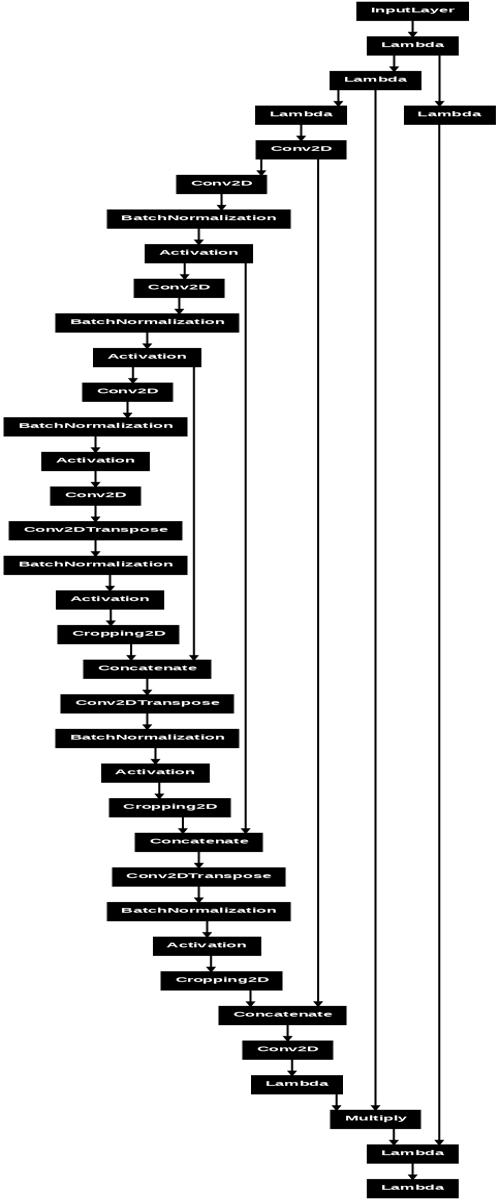


Attempting ResNet diagram with reduced DPI...
ResNet Diagram saved to: /kaggle/working/model_diagrams/resnet_diagram_small.png


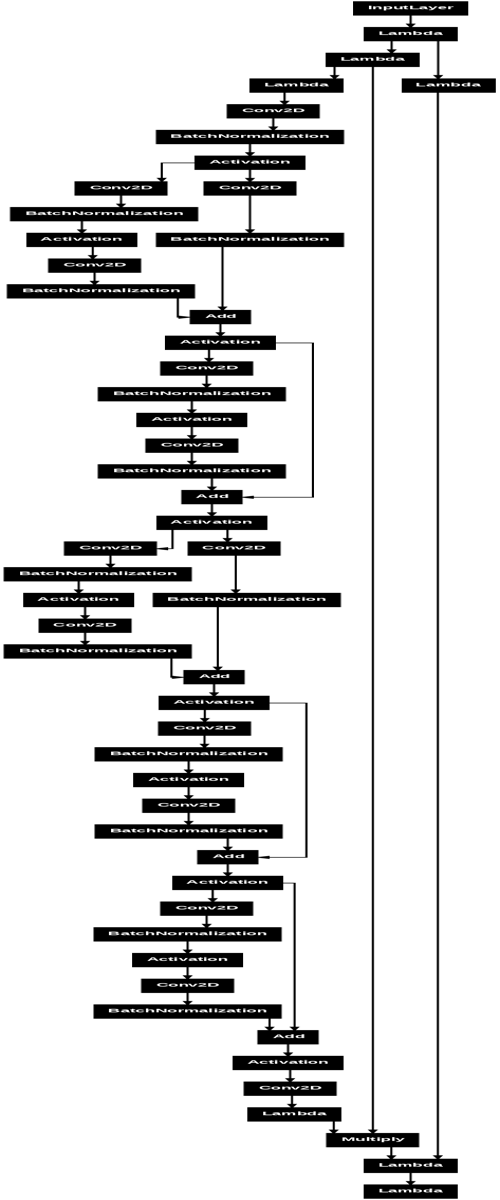

In [82]:
import os
from tensorflow import keras
import tensorflow as tf
from IPython.display import display
from PIL import Image

MODEL_DIAGRAM_DIR = '/kaggle/working/model_diagrams'
os.makedirs(MODEL_DIAGRAM_DIR, exist_ok=True)

LOWER_DPI = 72 
# Unet diagram
print("Attempting UNet diagram with reduced DPI...")
unet_path = os.path.join(MODEL_DIAGRAM_DIR, 'unet_diagram_small.png')
try:
    keras.utils.plot_model(
        model_unet, 
        to_file=unet_path, 
        show_shapes=False, 
        show_layer_names=False,
        rankdir='TB',
        dpi=LOWER_DPI 
    )
    print(f"UNet Diagram saved to: {unet_path}")
    display(Image.open(unet_path).resize((500, 1200))) 

except AssertionError as e:
    print(f"\nUNet plot failed: {e}")

# resnet diagram
print("\nAttempting ResNet diagram with reduced DPI...")
resnet_path = os.path.join(MODEL_DIAGRAM_DIR, 'resnet_diagram_small.png')
try:
    keras.utils.plot_model(
        model_resnet, 
        to_file=resnet_path, 
        show_shapes=False, 
        show_layer_names=False,
        rankdir='TB',
        dpi=LOWER_DPI 
    )
    print(f"ResNet Diagram saved to: {resnet_path}")
    display(Image.open(resnet_path).resize((500, 1200)))

except AssertionError as e:
    print(f"\nResNet plot failed: {e}")

## Custom Loss functions

In [34]:
def l1_mag_loss(true_audio, pred_audio):
    """
    l1 loss on the magnitude spectrograms (mae).
    penalizes differences in frequency content.
    """
    # difference in the magnitude, or signal strength
    Y = stft(true_audio)
    P = stft(pred_audio)
    return tf.reduce_mean(tf.abs(tf.abs(Y) - tf.abs(P)))

def l1_time_loss(true_audio, pred_audio):
    """
    l1 loss on the time-domain waveform (mae).
    encourages waveform matching.
    """
    # difference in the time domain, or difference of raw and reconstructed waveforms
    return tf.reduce_mean(tf.abs(true_audio - pred_audio))

def total_loss(true_audio, pred_audio):
     """
    weighted combination of time-domain and magnitude-domain L1 losses.
    """
    return (0.6 * l1_time_loss(true_audio, pred_audio) +
            0.4 * l1_mag_loss(true_audio, pred_audio))

In [35]:
def si_sdr(true_audio, pred_audio):
    """
    calculates the SI-SDR metric between true and predicted audio.
    """
    # decompose sound into two parts: projection (part which matches with clean output) and the rest
    # gets the ratio between the two
    x = true_audio
    s = pred_audio

    x_zm = x - tf.reduce_mean(x, axis=-1, keepdims=True)
    s_zm = s - tf.reduce_mean(x, axis=-1, keepdims=True)

    alpha_num = tf.reduce_sum(s_zm * x_zm, axis=-1, keepdims=True)
    alpha_den = tf.reduce_sum(x_zm**2, axis=-1, keepdims=True) + eps()
    alpha = alpha_num / alpha_den
    proj = alpha * x_zm

    e = s_zm - proj

    signal_power = tf.reduce_sum(proj**2, axis=-1)
    error_power = tf.reduce_sum(e**2, axis=-1)
    ratio = (signal_power + eps()) / (error_power + eps())

    si_sdr_val = 10.0 * tf.math.log(ratio) / tf.math.log(10.0)
    return si_sdr_val

## Custom Learning Rate for Optimzer

In [36]:
class WarmupCosine(keras.optimizers.schedules.LearningRateSchedule):
    """
    learning rate scheduler that applies a linear warmup followed by a 
    cosine decay to the base learning rate.
    """
    def __init__(self, base_lr, warmup_steps, total_steps):
        super().__init__()
        self.base_lr = base_lr
        self.warmup = warmup_steps
        self.total = total_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warm = tf.cast(self.warmup, tf.float32)
        total = tf.cast(self.total, tf.float32)
        # If step < warmup_steps, LR increases linearly.
        # Otherwise, LR follows a cosine curve decaying to zero.
        lr = tf.where(
            step < warm,
            self.base_lr * (step / tf.maximum(1.0, warm)),
            0.5 * self.base_lr * (1 + tf.cos(np.pi * (step - warm) / tf.maximum(1.0, (total-warm))))
        )
        return lr

In [37]:
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
lr_schedule = WarmupCosine(LEARNING_RATE, WARMUP_STEPS, TOTAL_STEPS)

opt_unet = keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam_UNet')
opt_resnet = keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam_ResNet')

## Exponential Moving Average

In [38]:
class EMA:
    """
    Manages Exponential Moving Average of model weights.
    The 'shadow' weights are used for inference/evaluation, while the regular 
    weights are used for training.
    """
    # shadow weights to store a smoother version of the training weights
    # shadow = old weight * decay rate + new weight * (1 - decay rate)
    def __init__(self, model, decay=EMA_DECAY):
        self.decay = decay
        self.trainable_vars = [w for w in model.weights if hasattr(w, 'assign')]
        self.shadow = [tf.Variable(tf.identity(w)) for w in self.trainable_vars]

    def update(self, model):
        """
        Updates the shadow weights: s = decay * s + (1 - decay) * w.
        """
        for w, s in zip(self.trainable_vars, self.shadow):
            s.assign(self.decay * s + (1.0 - self.decay) * w)

    def apply_to(self, model):
        self.backup = [tf.Variable(tf.identity(w)) for w in self.trainable_vars]
        for w, s in zip(self.trainable_vars, self.shadow):
            w.assign(s)

    def restore(self, model):
        for w, b in zip(self.trainable_vars, self.backup):
            w.assign(b)
        self.backup = None

In [39]:
ema_unet = EMA(model_unet, EMA_DECAY)
ema_resnet = EMA(model_resnet, EMA_DECAY)

train_loss_unet = keras.metrics.Mean(name='train_loss_unet')
val_loss_unet = keras.metrics.Mean(name='val_loss_unet')
train_si_sdr_unet = keras.metrics.Mean(name='train_si_sdr_unet')
val_si_sdr_unet = keras.metrics.Mean(name='val_si_sdr_unet')

train_loss_resnet = keras.metrics.Mean(name='train_loss_resnet')
val_loss_resnet = keras.metrics.Mean(name='val_loss_resnet')
train_si_sdr_resnet = keras.metrics.Mean(name='train_si_sdr_resnet')
val_si_sdr_resnet = keras.metrics.Mean(name='val_si_sdr_resnet')

In [40]:
def apply_gradients_safely(model, loss_metric, optimizer, ema, noisy, clean):
    """
    performs a single forward/backward pass and weight update for one model.
    includes gradient clipping and checks for unstable (nan/inf) gradients.
    """
    with tf.GradientTape() as tape:
        # Forward pass: model predicts enhanced audio, mask, and noisy magnitude
        enhanced_audio, mask, mag = model(noisy, training=True)
        loss_value = total_loss(clean, enhanced_audio)
        if tf.keras.mixed_precision.global_policy().compute_dtype == 'float16':
             loss_value = tf.cast(loss_value, tf.float32)

    # Calculate gradients
    grads = tape.gradient(loss_value, model.trainable_variables)

    # Gradient Clipping: prevents large gradients from causing instability
    grads, _ = tf.clip_by_global_norm(grads, clip_norm=5.0)

    filtered_grads_and_vars = []
    for grad, var in zip(grads, model.trainable_variables):
        if grad is not None:
            grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            grad = tf.where(tf.math.is_inf(grad), tf.zeros_like(grad), grad)
            filtered_grads_and_vars.append((grad, var))

    # Apply gradients and update weights
    optimizer.apply_gradients(filtered_grads_and_vars)

    # Update Exponential Moving Average of weights
    ema.update(model)
    loss_metric.update_state(loss_value)
    return enhanced_audio

In [41]:
@tf.function
def train_step_models(noisy, clean):
    # Train UNet
    enh_unet = apply_gradients_safely(model_unet, train_loss_unet, opt_unet, ema_unet, noisy, clean)
    train_si_sdr_unet.update_state(si_sdr(clean, enh_unet))

    # Train ResNet
    enh_resnet = apply_gradients_safely(model_resnet, train_loss_resnet, opt_resnet, ema_resnet, noisy, clean)
    train_si_sdr_resnet.update_state(si_sdr(clean, enh_resnet))

In [42]:
@tf.function
def val_step_models(noisy, clean):
    # Validate UNet
    enh_unet, _, _ = model_unet(noisy, training=False)
    val_loss_unet.update_state(total_loss(clean, enh_unet))
    val_si_sdr_unet.update_state(si_sdr(clean, enh_unet))

    # Validate ResNet
    enh_resnet, _, _ = model_resnet(noisy, training=False)
    val_loss_resnet.update_state(total_loss(clean, enh_resnet))
    val_si_sdr_resnet.update_state(si_sdr(clean, enh_resnet))

In [43]:
history = {
    'unet_loss': [], 'unet_val_loss': [], 'unet_si_sdr': [], 'unet_val_si_sdr': [],
    'resnet_loss': [], 'resnet_val_loss': [], 'resnet_si_sdr': [], 'resnet_val_si_sdr': [],
}
global_step = 0

print(f"\nTraining two models (UNet and ResNet) for comparison.")


Training two models (UNet and ResNet) for comparison.


In [44]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        print(f"- Name: {gpu.name}, Type: {gpu.device_type}")
else:
    print("WARNING: No GPUs detected by TensorFlow. Check your notebook settings.")

GPUs detected: 2
- Name: /physical_device:GPU:0, Type: GPU
- Name: /physical_device:GPU:1, Type: GPU


## EDA


--- Starting EDA on Sampled Training Data ---


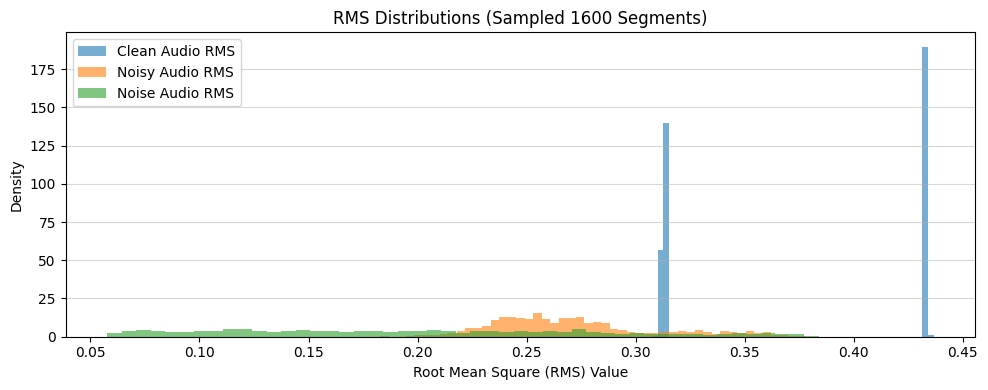

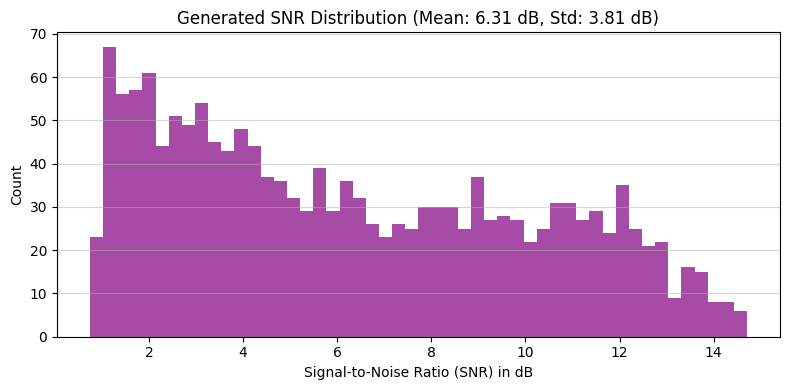

--- EDA Complete: Proceeding to Training ---


In [45]:
print("\n--- Starting EDA on Sampled Training Data ---")

NUM_BATCHES_FOR_EDA = 200

clean_rms, noisy_rms, noise_rms, snr_db = calculate_batch_metrics(
    train_ds, 
    num_batches_to_sample=NUM_BATCHES_FOR_EDA
)

plot_rms_distributions(clean_rms, noisy_rms, noise_rms, title=f"RMS Distributions (Sampled {NUM_BATCHES_FOR_EDA*BATCH_SIZE} Segments)")
plot_snr_distribution(snr_db, title=f"Generated SNR Distribution (Mean: {np.mean(snr_db):.2f} dB, Std: {np.std(snr_db):.2f} dB)")

print("--- EDA Complete: Proceeding to Training ---")

## Model Training: Training Unet model and Resnet model side by side

In [46]:
for epoch in range(1, EPOCHS+1):
    print(f'\nEpoch {epoch}/{EPOCHS}')

    # Reset metrics
    for metric in [train_loss_unet, val_loss_unet, train_si_sdr_unet, val_si_sdr_unet,
                   train_loss_resnet, val_loss_resnet, train_si_sdr_resnet, val_si_sdr_resnet]:
        metric.reset_state()

    for step, (noisy, clean) in enumerate(train_ds.take(STEPS_PER_EPOCH), start=1):
        train_step_models(noisy, clean)
        global_step += 1

        current_lr = lr_schedule(tf.constant(global_step, dtype=tf.int64)).numpy()

        if step % 100 == 0:
            print(f"  step {step}/{STEPS_PER_EPOCH} lr={current_lr:.6f} | "
                  f"UNet: L={train_loss_unet.result().numpy():.4f} SI-SDR={train_si_sdr_unet.result().numpy():.2f}dB | "
                  f"ResNet: L={train_loss_resnet.result().numpy():.4f} SI-SDR={train_si_sdr_resnet.result().numpy():.2f}dB")

    # Validation phase
    ema_unet.apply_to(model_unet)
    ema_resnet.apply_to(model_resnet)
    for step, (noisy, clean) in enumerate(val_ds.take(VAL_STEPS), start=1):
        val_step_models(noisy, clean)
    ema_unet.restore(model_unet)
    ema_resnet.restore(model_resnet)


    tr_loss_u, va_loss_u, tr_sdr_u, va_sdr_u = map(float, [train_loss_unet.result().numpy(), val_loss_unet.result().numpy(), train_si_sdr_unet.result().numpy(), val_si_sdr_unet.result().numpy()])
    tr_loss_r, va_loss_r, tr_sdr_r, va_sdr_r = map(float, [train_loss_resnet.result().numpy(), val_loss_resnet.result().numpy(), train_si_sdr_resnet.result().numpy(), val_si_sdr_resnet.result().numpy()])

    history['unet_loss'].append(tr_loss_u); history['unet_val_loss'].append(va_loss_u); history['unet_si_sdr'].append(tr_sdr_u); history['unet_val_si_sdr'].append(va_sdr_u)
    history['resnet_loss'].append(tr_loss_r); history['resnet_val_loss'].append(va_loss_r); history['resnet_si_sdr'].append(tr_sdr_r); history['resnet_val_si_sdr'].append(va_sdr_r)

    ema_unet.apply_to(model_unet)
    model_unet.save_weights(os.path.join(CHECKPOINT_DIR_UNET, f'epoch{epoch:02d}.weights.h5'))
    ema_unet.restore(model_unet)

    ema_resnet.apply_to(model_resnet)
    model_resnet.save_weights(os.path.join(CHECKPOINT_DIR_RESNET, f'epoch{epoch:02d}.weights.h5'))
    ema_resnet.restore(model_resnet)

    print(f"Epoch {epoch} done.")
    print(f"  UNet: Loss={tr_loss_u:.4f} / {va_loss_u:.4f} (Tr/Val) | SI-SDR={tr_sdr_u:.2f} / {va_sdr_u:.2f}dB (Tr/Val)")
    print(f"  ResNet: Loss={tr_loss_r:.4f} / {va_loss_r:.4f} (Tr/Val) | SI-SDR={tr_sdr_r:.2f} / {va_sdr_r:.2f}dB (Tr/Val)")


Epoch 1/6


I0000 00:00:1759844812.757231     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


  step 100/600 lr=0.000060 | UNet: L=0.4881 SI-SDR=5.31dB | ResNet: L=0.4417 SI-SDR=12.69dB
  step 200/600 lr=0.000120 | UNet: L=0.3426 SI-SDR=12.48dB | ResNet: L=0.2846 SI-SDR=16.30dB
  step 300/600 lr=0.000180 | UNet: L=0.2761 SI-SDR=15.65dB | ResNet: L=0.2231 SI-SDR=18.88dB
  step 400/600 lr=0.000240 | UNet: L=0.2373 SI-SDR=17.53dB | ResNet: L=0.1914 SI-SDR=20.60dB
  step 500/600 lr=0.000300 | UNet: L=0.2115 SI-SDR=18.68dB | ResNet: L=0.1715 SI-SDR=21.61dB
  step 600/600 lr=0.000299 | UNet: L=0.1931 SI-SDR=19.60dB | ResNet: L=0.1583 SI-SDR=22.31dB
Epoch 1 done.
  UNet: Loss=0.1931 / 0.7002 (Tr/Val) | SI-SDR=19.60 / -22.32dB (Tr/Val)
  ResNet: Loss=0.1583 / 0.2952 (Tr/Val) | SI-SDR=22.31 / 13.87dB (Tr/Val)

Epoch 2/6
  step 100/600 lr=0.000297 | UNet: L=0.1020 SI-SDR=23.51dB | ResNet: L=0.0954 SI-SDR=25.24dB
  step 200/600 lr=0.000293 | UNet: L=0.0974 SI-SDR=23.60dB | ResNet: L=0.0924 SI-SDR=25.52dB
  step 300/600 lr=0.000288 | UNet: L=0.0950 SI-SDR=23.57dB | ResNet: L=0.0914 SI-SDR=

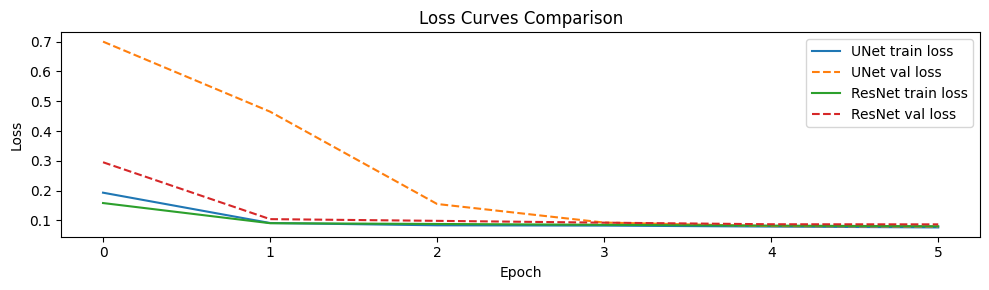

In [47]:
# Plotting results
plt.figure(figsize=(10,3))
plt.plot(history["unet_loss"], label="UNet train loss")
plt.plot(history["unet_val_loss"], label="UNet val loss", linestyle='--')
plt.plot(history["resnet_loss"], label="ResNet train loss")
plt.plot(history["resnet_val_loss"], label="ResNet val loss", linestyle='--')
plt.title("Loss Curves Comparison"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

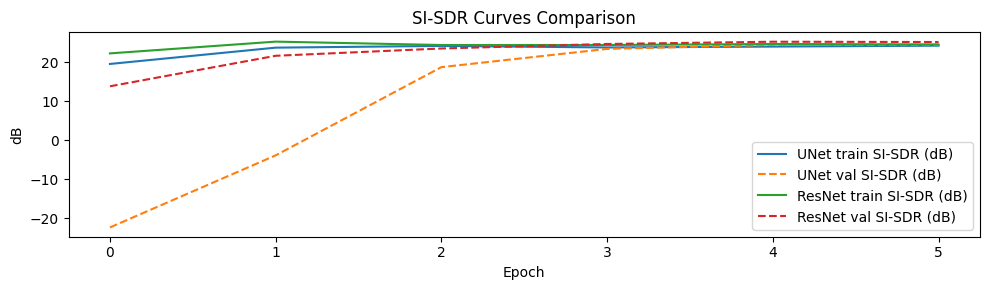

In [48]:
plt.figure(figsize=(10,3))
plt.plot(history["unet_si_sdr"], label="UNet train SI-SDR (dB)")
plt.plot(history["unet_val_si_sdr"], label="UNet val SI-SDR (dB)", linestyle='--')
plt.plot(history["resnet_si_sdr"], label="ResNet train SI-SDR (dB)")
plt.plot(history["resnet_val_si_sdr"], label="ResNet val SI-SDR (dB)", linestyle='--')
plt.title("SI-SDR Curves Comparison"); plt.xlabel("Epoch"); plt.ylabel("dB"); plt.legend(); plt.tight_layout(); plt.show()

## Qualitative Check

In [49]:
print("\n--- Qualitative Check on Validation Sample ---")

noisy_b, clean_b = next(iter(val_ds))
idx = 0
noisy = noisy_b[idx].numpy()
clean = clean_b[idx].numpy()

ema_unet.apply_to(model_unet)
enh_unet_b, mask_unet_b, mag_unet_b = model_unet(noisy_b, training=False)
ema_unet.restore(model_unet)
enh_unet = enh_unet_b[idx].numpy()

ema_resnet.apply_to(model_resnet)
enh_resnet_b, mask_resnet_b, mag_resnet_b = model_resnet(noisy_b, training=False)
ema_resnet.restore(model_resnet)
enh_resnet = enh_resnet_b[idx].numpy()

sdr_unet = si_sdr(clean_b[idx:idx+1], enh_unet_b[idx:idx+1]).numpy()[0]
sdr_resnet = si_sdr(clean_b[idx:idx+1], enh_resnet_b[idx:idx+1]).numpy()[0]

print(f"Sample SI-SDR: UNet = {sdr_unet:.2f}dB | ResNet = {sdr_resnet:.2f}dB")


--- Qualitative Check on Validation Sample ---
Sample SI-SDR: UNet = 25.51dB | ResNet = 24.97dB


In [50]:
if sdr_unet > sdr_resnet:
    best_enh = enh_unet
    best_mask = mask_unet_b[idx].numpy()
    best_name = "UNet"
else:
    best_enh = enh_resnet
    best_mask = mask_resnet_b[idx].numpy()
    best_name = "ResNet"

print(f"The best model for this sample is the: **{best_name}**")

The best model for this sample is the: **UNet**


## Visualizing Results

In [51]:
print("\nPlaying audio (Noisy -> Clean -> UNet Enhanced -> ResNet Enhanced)")
display(Audio(noisy, rate=SR, embed=True, autoplay=False))
display(Audio(clean, rate=SR, embed=True, autoplay=False))
display(Audio(enh_unet, rate=SR, embed=True, autoplay=False))
display(Audio(enh_resnet, rate=SR, embed=True, autoplay=False))

N_spec = stft(noisy)
C_spec = stft(clean)
E_u_spec = stft(enh_unet)
E_r_spec = stft(enh_resnet)



Playing audio (Noisy -> Clean -> UNet Enhanced -> ResNet Enhanced)


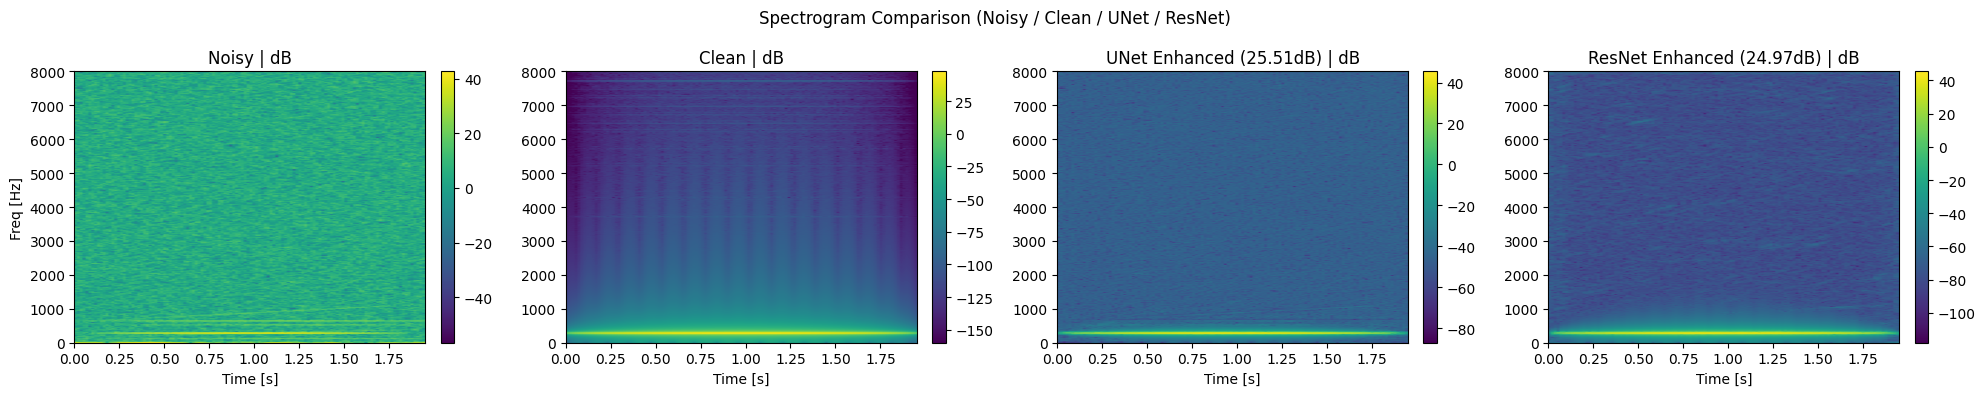

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

specs = [np.abs(N_spec), np.abs(C_spec), np.abs(E_u_spec), np.abs(E_r_spec)]
titles = ["Noisy | dB", "Clean | dB", f"UNet Enhanced ({sdr_unet:.2f}dB) | dB", f"ResNet Enhanced ({sdr_resnet:.2f}dB) | dB"]

for i, (spec, title) in enumerate(zip(specs, titles)):
    im = axs[i].imshow(spec_db(spec).T, origin="lower", aspect="auto",
                       extent=[0, spec.shape[0]*HOP/SR, 0, SR/2])
    axs[i].set_title(title)
    axs[i].set_xlabel("Time [s]");
    if i == 0: axs[i].set_ylabel("Freq [Hz]")
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)

plt.suptitle("Spectrogram Comparison (Noisy / Clean / UNet / ResNet)")
plt.tight_layout()
plt.show()

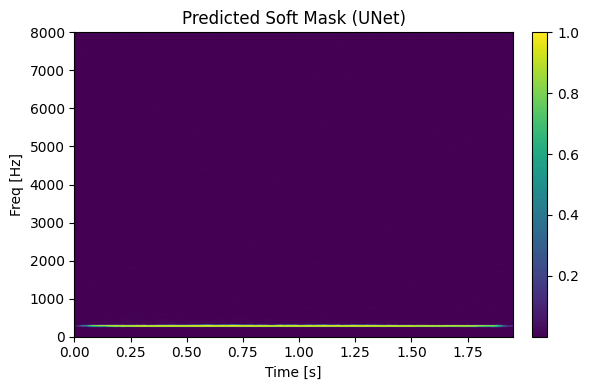

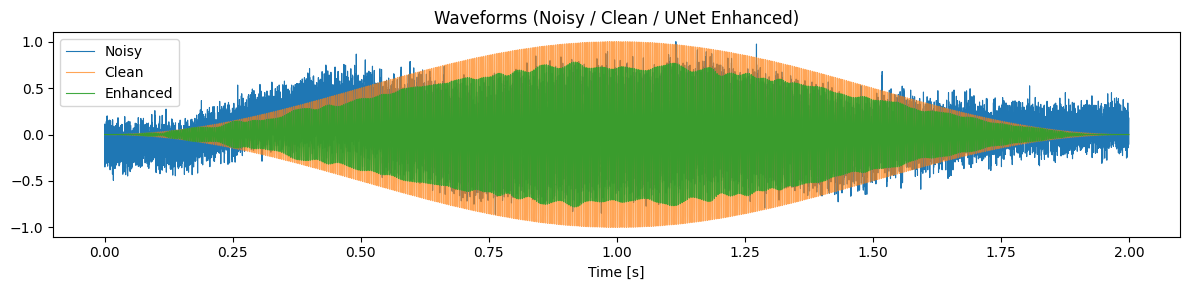

In [54]:
plot_mask(best_mask, title=f"Predicted Soft Mask ({best_name})")
plot_waveforms(noisy, clean, best_enh, sr=SR, title=f"Waveforms (Noisy / Clean / {best_name} Enhanced)")

## Picking the Best Model based on val score

In [55]:
final_val_sdr_u = history['unet_val_si_sdr'][-1] if history['unet_val_si_sdr'] else -np.inf
final_val_sdr_r = history['resnet_val_si_sdr'][-1] if history['resnet_val_si_sdr'] else -np.inf

if final_val_sdr_u >= final_val_sdr_r:
    best_model = model_unet
    best_ema = ema_unet
    export_path = EXPORT_DIR_UNET
    best_model_name = "UNet"
else:
    best_model = model_resnet
    best_ema = ema_resnet
    export_path = EXPORT_DIR_RESNET
    best_model_name = "ResNet"

print(f"\nOverall Best Model (based on final val SI-SDR): **{best_model_name}** ({max(final_val_sdr_u, final_val_sdr_r):.2f}dB)")



Overall Best Model (based on final val SI-SDR): **ResNet** (25.22dB)


In [56]:
best_ema.apply_to(best_model)

In [57]:
class InferenceWrapper(keras.Model):
    def __init__(self, base):
        super().__init__()
        self.base = base
    @tf.function(input_signature=[tf.TensorSpec([None], tf.float32)])
    def denoise(self, audio):
        audio = tf.expand_dims(audio, 0)
        enh, _mask, _mag = self.base(audio, training=False)
        return tf.squeeze(enh, 0)

In [58]:
infer_model = InferenceWrapper(best_model)
try:
    tf.saved_model.save(infer_model, export_path)
    print(f"Best model ({best_model_name}) Exported to: {export_path}")
except Exception as e:
    print(f"WARNING: Could not export model (check training success). Error: {e}")

best_ema.restore(best_model)

print("\nReady! Use: denoise_file('/kaggle/input/your.wav', out_path='/kaggle/working/clean.wav', show=True)") 

Best model (ResNet) Exported to: /kaggle/working/denoiser_export/resnet

Ready! Use: denoise_file('/kaggle/input/your.wav', out_path='/kaggle/working/clean.wav', show=True)


In [59]:
def denoise_file(wav_path, out_path=None, show=True):
    y, _ = read_wav_mono(wav_path, SR)
    T = len(y)

    pad = ( (math.ceil(T / SEGMENT) * SEGMENT) - T )
    y_pad = np.pad(y, (0, pad), mode='reflect').astype(np.float32)

    best_ema.apply_to(best_model)
    if T != SEGMENT:
        print("WARNING: Inference function is simplistic. Only inputs of length 32000 are guaranteed to work.")

    enh, _, _ = best_model(tf.convert_to_tensor(y_pad[None, ...]), training=False)
    best_ema.restore(best_model)

    enh = enh.numpy()[0][:T]

    if out_path:
        write_wav(out_path, enh, SR)

    if show:
        print("Playing (Noisy -> Enhanced)")
        display(Audio(y, rate=SR))
        display(Audio(enh, rate=SR))
        N_spec = stft(y)
        E_spec = stft(enh)
        plot_spectrograms(np.abs(N_spec).numpy(), None, np.abs(E_spec).numpy(), sr=SR, title="Noisy / Enhanced Spectrogram (dB)")
        plot_waveforms(y, None, enh, sr=SR, title="Inference Waveforms")

    return enh


Demo playback:


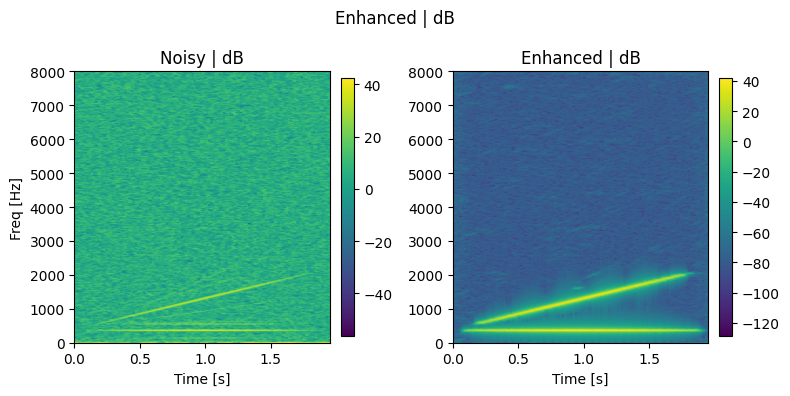

In [62]:
demo_clean = gen_tone(2.0)
demo_noise = gen_noise(2.0)
demo_noisy, demo_clean, _ = mix_clean_noise(demo_clean, demo_noise, snr_db=0.0)
print("\nDemo playback:")
display(Audio(demo_noisy, rate=SR))
best_ema.apply_to(best_model)
demo_enh, _, _ = best_model(tf.convert_to_tensor(demo_noisy[None, ...]), training=False)
best_ema.restore(best_model)
demo_enh = demo_enh.numpy()[0]
display(Audio(demo_enh, rate=SR))
N_demo_spec = stft(demo_noisy)
E_demo_spec = stft(demo_enh)
plot_spectrograms(np.abs(N_demo_spec), None, np.abs(E_demo_spec), title="Demo Noisy / Enhanced Spec (dB)")